# Service Components

***
* Downloaded service-components data from the "market analysis" view. 
* "Components" column  reflects what the organizations <b>actually</b> use a particular product for.
    * Renamed to "components_orgs_actually_use" to make this a little clearer.

In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = 64
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.options.display.float_format = "{:.2f}".format

from collections import Counter, OrderedDict
from itertools import chain
from os import path

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from calitp import *
from IPython.display import HTML, Image, Markdown, display, display_html
from PIL import Image
from shared_utils import altair_utils
from siuba import *

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/transit_stacks/"

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


In [2]:
service_components = to_snakecase(
    pd.read_csv(f"{GCS_FILE_PATH}service-components-Market Analysis.csv")
)

In [3]:
f"{len(service_components)} rows"

'1032 rows'

In [4]:
service_components.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032 entries, 0 to 1031
Data columns (total 8 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   name                                              1032 non-null   object
 1   services                                          1027 non-null   object
 2   component                                         1030 non-null   object
 3   vendor__from_product_                             950 non-null    object
 4   parent_organization__from_vendor___from_product_  247 non-null    object
 5   provider__from_services_                          1027 non-null   object
 6   product                                           1030 non-null   object
 7   product_components                                973 non-null    object
dtypes: object(8)
memory usage: 64.6+ KB


In [5]:
# Fill in N/A and rename cols to be a little clearer.
service_components = service_components.fillna("N/A").rename(
    columns={
        "component": "components_orgs_actually_use",
        "product_components": "all_components_in_product",
    }
)

In [6]:
# Drop Duplicates
service_components = service_components.drop_duplicates()

In [7]:
display(
    Markdown(
        f"The length of the dataframe went down to {len(service_components)} after dropping duplicates"
        "<br>"
        f"There are {service_components.services.nunique()} different organizations."
        "<br>"
        f" There are {service_components.components_orgs_actually_use.nunique()} different components."
    )
)

The length of the dataframe went down to 1023 after dropping duplicates<br>There are 156 different organizations.<br> There are 26 different components.

In [8]:
# Copy dataframe to not mess the original one.
service_components2 = service_components.copy()

In [9]:
# Find if a value in "components_usage" matches a value in "all components in product" column because sometimes, they don't match?
# If there is at least one match, tag as "True."

# https://stackoverflow.com/questions/21514191/check-if-pandas-column-contains-value-from-another-column
service_components2["contained"] = service_components2.apply(
    lambda x: x.components_orgs_actually_use in x.all_components_in_product, axis=1
)

In [10]:
# De duplicate provider from services & remove unnecessary quotation marks
# https://stackoverflow.com/questions/56466917/is-there-a-way-in-pandas-to-remove-duplicates-from-within-a-series
service_components2["provider__from_services_"] = (
    service_components2["provider__from_services_"]
    .apply(lambda x: ", ".join(set([y.strip() for y in x.split(",")])))
    .str.strip()
    .replace({'"': ""}, regex=True)
)

In [11]:
# Some of the de  duplicating left things like "Davis, University of California Davis." So grab only second element behind the comma ,if there is a comma.
service_components2["provider__from_services_"] = (
    service_components2["provider__from_services_"].str.rsplit(",").str[-1]
)

In [12]:
# Double check that this worked properly.
service_components2[
    [
        "services",
        "provider__from_services_",
        "product",
        "components_orgs_actually_use",
        "all_components_in_product",
        "contained",
    ]
].sample(3)

,services,provider__from_services_,product,components_orgs_actually_use,all_components_in_product,contained
737,Gold Coast Transit,Gold Coast Transit,Token Transit Mobile Ticketing,Mobile ticketing,Mobile ticketing,True
923,"WestCAT Local,WestCAT Lynx Express,WestCAT Express Bus to BART",Western Contra Costa Transit Authority,Digital Recorders - Unspecified,Headsigns,N/A,False
468,Anaheim Resort Transportation,Anaheim Transportation Network,GMV/Syncromatics Dispatch,Mobile data terminal software,"Computer Automated Dispatch (Fixed),Location Sensors,AVL On-board Computer,AVL Software,APC Software",False


In [13]:
# Count how many true and false.
service_components2.contained.value_counts()

False    548
True     475
Name: contained, dtype: int64

## Summarizing the DataFrame
***
* It looks like some services/organizations use the same product from the same vendor for 1+ components but this is split on 2 lines.
    * Example: Tuolumne County Transit uses Doublemap RealTime product for both real-time and arrival predictions. 
    * However, 'real-time' and 'arrival predictions' are split on  different lines, even though they reference the same product, vendor, and customer.
    * <img src="Example_Tuolumne.png" width=1000 height=400 />
* Group/summarize so the same service-vendor-product combination on the same line to avoid duplicate entires.

In [14]:
# Copy dataframe to not mess the original one.
service_components3 = service_components2.copy()

In [15]:
# Group the column "components_orgs_actually_use" based on services/organizations, vendor, and product
service_components3["components_usage"] = service_components3.groupby(
    ["provider__from_services_", "vendor__from_product_", "product"]
)["components_orgs_actually_use"].transform(lambda x: ",".join(x))

In [16]:
# Sort dataframe by the columns "product" and "contained". Thus, if a product-company-agency combination has one true, we would capture it.
service_components3 = service_components3.sort_values(
    by=["product", "contained"], ascending=False
)

In [17]:
# Drop the  duplicates by certain columns
service_components3 = service_components3.drop_duplicates(
    subset=[
        "provider__from_services_",
        "product",
        "vendor__from_product_",
        "components_usage",
    ],
    keep="first",
)

In [18]:
# Keep only columns of interest
service_components3 = service_components3[
    [
        "services",
        "vendor__from_product_",
        "provider__from_services_",
        "parent_organization__from_vendor___from_product_",
        "product",
        "all_components_in_product",
        "components_usage",
        "contained",
    ]
]

In [19]:
# Double checking
service_components3[
    (service_components3.services.str.contains("GET Bus,GET Bus On Demand", case=False))
]

,services,vendor__from_product_,provider__from_services_,parent_organization__from_vendor___from_product_,product,all_components_in_product,components_usage,contained
35,"GET Bus,GET Bus On Demand",Worldpay,Golden Empire Transit District,Fidelity National Information Services,Worldpay,Payment processor,Payment processor,True
2,"GET Bus,GET Bus On Demand",UTA,Golden Empire Transit District,N/A,UTA APC Software,APC Software,APC Software,True
58,"GET Bus,GET Bus On Demand",Transit App Inc.,Golden Empire Transit District,N/A,Transit App,Mobile trip planning app,Alerts Content Management System,False
8,"GET Bus,GET Bus On Demand",TransTrack Solutions Group,Golden Empire Transit District,N/A,TransTrack Manager,"Data Analysis/GIS/Modelling Software,KPI Reporting","KPI Reporting,KPI Reporting",True
1,"GET Bus,GET Bus On Demand",Token Transit,Golden Empire Transit District,N/A,Token Transit Mobile Ticketing,Mobile ticketing,Mobile ticketing,True
96,"GET Bus,GET Bus On Demand",SunriseSESA,Golden Empire Transit District,N/A,Sunrise CDP,"General Signage ,Interior signage,Headsigns,Side signs",Offboard signage,False
17,"GET Bus,GET Bus On Demand",Optibus,Golden Empire Transit District,N/A,Optibus,"Scheduling (Fixed-route),GTFS Schedule Publishing,GTFS generation",Scheduling (Fixed-route),True
24,"GET Bus,GET Bus On Demand",Hanover Displays Ltd,Golden Empire Transit District,N/A,Hanover Headsigns,Headsigns,Headsigns,True
0,"GET Bus,GET Bus On Demand",Genfare,Golden Empire Transit District,N/A,Genfare Farebox (Unspecified),Cash Farebox,Cash Farebox,True
3,"GET Bus,GET Bus On Demand",Connexionz Inc.,Golden Empire Transit District,N/A,Connextionz Vehicle and Shelter Displays,Offboard signage,Interior signage,False


In [20]:
len(service_components3)

697

In [21]:
service_components3.contained.value_counts()

True     435
False    262
Name: contained, dtype: int64

## Are there vendors that offer GTFS & Real Time that nobody is using?
***

* No. There are even more vendors in the service component dataset compared to the products data set.

In [22]:
# Filter out products that have GTFS and Scheduling in service components dataset
gtfs_rt = service_components[
    service_components["all_components_in_product"].str.contains("GTFS", case=False)
    & service_components["all_components_in_product"].str.contains(
        "real-time", case=False
    )
]

In [23]:
# Double check
# gtfs_rt

In [24]:
# Read in products data set
FILE_NAME = "transit_stacks.xlsx"
products = pd.read_excel(f"{GCS_FILE_PATH}{FILE_NAME}", sheet_name="products_clean")

In [25]:
# Filter out products that have GTFS and Scheduling in products dataset
products_gtfs_rt = products[
    products["components"].str.contains("GTFS", case=False)
    & products["components"].str.contains("real-time", case=False)
]

In [26]:
# Grab unique vendors and change it to a set for PRODUCTS table.
products_vendors = set(products_gtfs_rt.vendor.unique().tolist())
products_vendors

{'GMV Syncromatics Inc', 'Swiftly Inc.', 'TripShot Inc.', 'Uber Inc.'}

In [27]:
# Grab unique vendors and chane it to a set for SERVICE COMPONENTS table.
service_comps_vendors = set(gtfs_rt.vendor__from_product_.unique().tolist())
service_comps_vendors

{'DoubleMap Inc.,Nixle',
 'GMV Syncromatics Inc',
 'Optibus,GMV Syncromatics Inc',
 'Swiftly Inc.',
 'Token Transit,Uber Inc.',
 'TripShot Inc.',
 'Uber Inc.',
 'Uber Inc.,Uber Inc.'}

In [28]:
# Look at the set
products_vendors - service_comps_vendors

set()

## How many components are organizations <i>actually</i> using vs. how many components a product actually offers?
***


In [29]:
# Number of components an organization uses that product for (clean this up with assign later)
# Count number of values by commas
# https://stackoverflow.com/questions/30202011/how-can-i-count-comma-separated-values-in-one-column-of-my-panda-table
service_components3["number_of_components_used"] = (
    service_components3["components_usage"]
    .apply(lambda x: len(x.split(",")))
    .astype("int64")
)
# Number of components available in the product
service_components3["number_of_components_avail"] = (
    service_components3["all_components_in_product"]
    .apply(lambda x: len(x.split(",")))
    .astype("int64")
)

In [30]:
# Double checking
service_components3[
    [
        "product",
        "provider__from_services_",
        "all_components_in_product",
        "number_of_components_avail",
        "components_usage",
        "number_of_components_used",
    ]
].sample(4)

,product,provider__from_services_,all_components_in_product,number_of_components_avail,components_usage,number_of_components_used
293,Trapeze Traveler Experience,Long Beach Transit,Real-time info,1,"Arrival predictions,Alerts Content Management System",2
291,Cubic NextBus Suite,Foothill Transit,Real-time info,1,Arrival predictions,1
422,Connextionz CAD/AVL,Kings County Area Public Transit Agency,"AVL Software,Computer Automated Dispatch (Responsive)",2,"Arrival predictions,AVL Software",2
331,Avail myAvail Enterprise Transit Management Software,City of Santa Rosa,Human Resources,1,AVL Software,1


### Find mean of components available across all products
***

In [31]:
# Subset
avail_components = service_components3[
    [
        "vendor__from_product_",
        "product",
        "all_components_in_product",
        "components_usage",
        "number_of_components_used",
        "number_of_components_avail",
    ]
]

In [32]:
# Drop duplicates, we only want one row per product-vendor-component combo
avail_components = avail_components.drop_duplicates(
    ["vendor__from_product_", "product", "all_components_in_product"]
)

In [33]:
len(avail_components)

207

In [34]:
avail_components["number_of_components_avail"].mean()

2.42512077294686

In [35]:
avail_components.number_of_components_avail.value_counts()

1     94
2     47
3     22
4     15
5     10
6      9
8      4
10     2
7      2
9      2
Name: number_of_components_avail, dtype: int64

In [36]:
service_components3[service_components3["number_of_components_used"] == 13]

,services,vendor__from_product_,provider__from_services_,parent_organization__from_vendor___from_product_,product,all_components_in_product,components_usage,contained,number_of_components_used,number_of_components_avail


In [37]:
# Group to by how many components available versus how many components are actually being used. Count organizations - unique.
components_used = (
    service_components3.groupby(
        ["number_of_components_avail", "number_of_components_used"]
    )
    .agg({"provider__from_services_": "nunique"})
    .rename(columns={"provider__from_services_": "Count of Organizations"})
)

In [38]:
# Rename index
components_used.index.names = ["# of Components Available", "# of Components Used"]

* Most organizations (105) use a product with only one component available anyway.
* The next most common combination: 2 components are available for a product, but only 1 product is used.
* There are some crazy skews.
* For example: Placer County uses Cubic Next Suite for 8 different task but Cubic Next Suite has 1 component listed - hence the crazy skew.
* <img src="Example_Placer.png" width=1000 height=250 />

In [152]:
components_used.style.set_properties(**{"background-color": "white"}).bar(
    subset=["Count of Organizations"], color="#2EA8CE"
)

In [40]:
# components_used.reset_index()

## Why are organizations only buying/using certain components but not others?
***
* Maybe look at it using "function group" in components dataset to see if there are particular categories where organizations are only buying certain components.
* Only look at products with more than one component available. 


In [41]:
# Read in components data set
FILE_NAME = "transit_stacks.xlsx"
components = pd.read_excel(f"{GCS_FILE_PATH}{FILE_NAME}", sheet_name="components_clean")

In [42]:
# Keep only certain columns
components = components[["name", "function_group", "products"]].copy()

In [43]:
components["function_group"] = components["function_group"].replace(
    {"Rider info": "Rider Info"}
)

In [44]:
components.head(2)

,name,function_group,products
0,Advertising Agency,NaN,Intersection
1,Alerts Content Management System,Rider Info,"IBI Alerts,RouteShout,RouteMatch - Demand: Notifications Module,Trillium Trip Alerts,Swiftly Transitime,Nixle Engage"


In [45]:
# Explode the dataframe - take out all the values in products split by comma and put each value in its own row
# https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe
components2 = (
    components.set_index(["name", "function_group"])
    .apply(lambda x: x.str.split(",").explode())
    .reset_index()
)

In [46]:
components2.head()

,name,function_group,products
0,Advertising Agency,NaN,Intersection
1,Alerts Content Management System,Rider Info,IBI Alerts
2,Alerts Content Management System,Rider Info,RouteShout
3,Alerts Content Management System,Rider Info,RouteMatch - Demand: Notifications Module
4,Alerts Content Management System,Rider Info,Trillium Trip Alerts


In [47]:
# Merge on the right
merge3 = pd.merge(
    components2,
    service_components3,
    left_on="products",
    right_on="product",
    indicator=True,
    how="right",
)

In [48]:
merge4 = merge3.drop_duplicates()

In [49]:
merge4._merge.value_counts()

both          1098
right_only      96
left_only        0
Name: _merge, dtype: int64

In [50]:
# Filter out for merge only "both" and products with more than 1 component available.
merge4 = merge4[
    (merge4["_merge"] == "both") & (merge4["number_of_components_avail"] > 1)
]

In [51]:
merge4 = merge4[
    [
        "function_group",
        "product",
        "vendor__from_product_",
        "services",
        "parent_organization__from_vendor___from_product_",
        "number_of_components_used",
        "number_of_components_avail",
    ]
].copy()

In [52]:
# Not sure why there are STILL tons of duplicates even tho I dropped them a few cells up. Dropping them again
merge4 = merge4.drop_duplicates()

In [53]:
merge4.sample(3)

,function_group,product,vendor__from_product_,services,parent_organization__from_vendor___from_product_,number_of_components_used,number_of_components_avail
102,Rider Info,Trillium GTFS Manager,Trillium Inc.,"WestCAT Express Bus to BART,WestCAT Local,WestCAT Lynx Express",N/A,1,2
181,Scheduling,Trapeze Fixed Route Scheduling,Trapeze Group,"VTA Bus,VTA ACE Shuttles,VTA Light Rail,VTA Rapid Bus,VTA Express Bus,VTA School Tripper",Modaxo Inc,2,2
76,Rider Info,Trillium GTFS Manager,Trillium Inc.,"El Dorado Transit,Sacramento/South Lake Tahoe Connector Bus,El Dorado Dial-A-Ride,SAC-MED,El Dorado Paratransit",N/A,2,2


In [54]:
len(merge4)

362

In [55]:
function_summary = (
    merge4.groupby(["function_group"])
    .agg({"number_of_components_avail": "mean", "number_of_components_used": "mean"})
    .reset_index()
)

In [56]:
function_summary["Ratio of Components Available vs Used"] = (
    function_summary["number_of_components_avail"]
    / function_summary["number_of_components_used"]
).round(1)

In [57]:
function_summary = function_summary.rename(
    columns={
        "function_group": "Function",
        "number_of_components_avail": "Average # of Components for Products with 1+ Components",
        "number_of_components_used": "Average # of Components Used",
    }
)

* Attempting to see if there's anything interesting by the 7 choices in Function instead of using components, which has 26 different groups. 
* Backoffice has an average of '2.96' components per product that falls into its category, but only '1.44' components are used on average by an agency. About 2 components available for every 1 used.
* Reporting has the highest mean of components for its products (4.96) but organizations only use 1.71 components on average...But it doesn't have the highest ratio: Operations does.

In [58]:
function_summary.sort_values("Average # of Components for Products with 1+ Components")

,Function,Average # of Components for Products with 1+ Components,Average # of Components Used,Ratio of Components Available vs Used
2,IT,2.00,1.00,2.00
6,Scheduling,2.52,1.74,1.50
0,Backoffice,2.96,1.57,1.90
5,Rider Info,3.12,1.51,2.10
1,Fare collection,4.45,2.25,2.00
3,Operations,4.88,1.73,2.80
4,Reporting,5.05,1.95,2.60


In [59]:
utils.basic_bar_chart(
    function_summary,
    "Ratio of Components Available vs Used",
    "Function",
    "Function",
    "Ratio of Components Available vs Components Used",
)

alt.Chart(...)

## Which components are organizations "buying twice" theoretically?
***

* Products can have multiple functions.
* Organizations buy multiple products and these products they buy potentially have the same components.
* See which components are appear more than once in the various products an organization has purchased.

Draft findings:
* 34 different organizations bought more than 1 product with real-time capabilities.
* 11 " " with offboard signage capabilities.
* 9 " " with scheduling (fixed-route) feature.

In [60]:
service_components3[service_components3["provider__from_services_"] == "OmniTrans"]

,services,vendor__from_product_,provider__from_services_,parent_organization__from_vendor___from_product_,product,all_components_in_product,components_usage,contained,number_of_components_used,number_of_components_avail
672,"OmniTrans,OmniTrans sbX",Trapeze Group,OmniTrans,Modaxo Inc,Trapeze Signage,General Signage,"Headsigns,Interior signage",False,2,1
140,"OmniTrans,OmniTrans sbX",Trapeze Group,OmniTrans,Modaxo Inc,Trapeze Fixed Route Scheduling,"Run cutting,Driver Sign-up",Scheduling (Fixed-route),False,1,2
673,"OmniTrans,OmniTrans sbX",Trapeze Group,OmniTrans,Modaxo Inc,Trapeze Annunciator,Annunciator,Annunciator,True,1,1
464,"OmniTrans,OmniTrans sbX",Trapeze Group,OmniTrans,Modaxo Inc,Trapeze - Unspecified,"Scheduling (Fixed-route),GTFS generation","Mobile data terminal software,APC Software",False,2,2
1026,"OmniTrans,OmniTrans sbX,OmniRide",Transit App Inc.,OmniTrans,N/A,Transit Royale,"Mobile trip planning app,Alerts Subscription Service",Mobile trip planning app,True,1,2
896,"OmniTrans,OmniTrans sbX",TransTrack Solutions Group,OmniTrans,N/A,TransTrack Manager,"Data Analysis/GIS/Modelling Software,KPI Reporting",KPI Reporting,True,1,2
749,"OmniTrans,OmniTrans sbX",Token Transit,OmniTrans,N/A,Token Transit Mobile Ticketing,Mobile ticketing,Mobile ticketing,True,1,1
261,"OmniTrans,OmniTrans sbX",N/A,OmniTrans,N/A,In house activity,N/A,GTFS generation,False,1,1
842,"OmniTrans,OmniTrans sbX",Genfare,OmniTrans,N/A,Genfare Farebox (Unspecified),Cash Farebox,Cash Farebox,True,1,1
962,"OmniTrans,OmniTrans sbX",Genfare,OmniTrans,N/A,GenFare TVM (Unspecified),Ticket Vending Machines,Ticket Vending Machines,True,1,1


In [61]:
# Summarizing dataframe even more
# For each service/organization, place ALL the products used, all components in a product, and all the components a service uses on to one row.
services_products = (
    service_components3.groupby("provider__from_services_")["product"]
    .apply(",".join)
    .reset_index()
)

In [62]:
services_products.head(2)

,provider__from_services_,product
0,Golden Gate Bridge,"VenTek venSTATION,TransTrack Manager,In house activity,In house activity,INIT (Unspecified Model),Giro HASTUS,Genfare Farebox (Unspecified),Cubic - Unspecified"
1,Solano County Transit,"Transit Royale,Cubic NextBus Suite"


In [63]:
services_components_in_products = (
    service_components3.groupby("provider__from_services_")["all_components_in_product"]
    .apply(",".join)
    .reset_index()
)

In [64]:
services_components_in_products.head(2)

,provider__from_services_,all_components_in_product
0,Golden Gate Bridge,"Cash Farebox,Ticket Vending Machines,Data Analysis/GIS/Modelling Software,KPI Reporting,N/A,Driver Sign-up,Scheduling (Fixed-route),KPI Reporting,Cash Farebox,Mobile ticketing,Real-time info,Scheduling (Fixed-route),GTFS generation,Cash Farebox,AVL On-board Computer,AVL Software,Location Sensors,Real-time info,Arrival predictions,Fare card system,Mobile ticketing,Contactless Payment Validators"
1,Solano County Transit,"Mobile trip planning app,Alerts Subscription Service,Real-time info"


In [65]:
services_components_used = (
    service_components3.groupby("provider__from_services_")["components_usage"]
    .apply(",".join)
    .reset_index()
)

In [66]:
services_components_used.head(2)

,provider__from_services_,components_usage
0,Golden Gate Bridge,"Ticket Vending Machines,KPI Reporting,Alerts Content Management System,Arrival predictions,AVL Software,Mobile data terminal software,Offboard signage,Annunciator,Headsigns,Interior signage,APC Software,Scheduling (Fixed-route),GTFS generation,Cash Farebox,Payment processor"
1,Solano County Transit,"Mobile trip planning app,Real-time info"


In [67]:
# Merge the dataframes together on provider__from_services_
merge1 = pd.merge(
    services_products, services_components_in_products, on="provider__from_services_"
)

In [68]:
merge1.head(1)

,provider__from_services_,product,all_components_in_product
0,Golden Gate Bridge,"VenTek venSTATION,TransTrack Manager,In house activity,In house activity,INIT (Unspecified Model),Giro HASTUS,Genfare Farebox (Unspecified),Cubic - Unspecified","Cash Farebox,Ticket Vending Machines,Data Analysis/GIS/Modelling Software,KPI Reporting,N/A,Driver Sign-up,Scheduling (Fixed-route),KPI Reporting,Cash Farebox,Mobile ticketing,Real-time info,Scheduling (Fixed-route),GTFS generation,Cash Farebox,AVL On-board Computer,AVL Software,Location Sensors,Real-time info,Arrival predictions,Fare card system,Mobile ticketing,Contactless Payment Validators"


In [69]:
services_components_used.head(1)

,provider__from_services_,components_usage
0,Golden Gate Bridge,"Ticket Vending Machines,KPI Reporting,Alerts Content Management System,Arrival predictions,AVL Software,Mobile data terminal software,Offboard signage,Annunciator,Headsigns,Interior signage,APC Software,Scheduling (Fixed-route),GTFS generation,Cash Farebox,Payment processor"


In [70]:
merge2 = pd.merge(
    merge1, services_components_used, on="provider__from_services_"
).rename(
    columns={
        "product": "products purchased",
        "all_components_in_product": "available components across all purchased products",
        "components_usage": "components used",
    }
)

In [71]:
# Double check that we have the same number of orgs in merge2 as our original df.
merge2.provider__from_services_.nunique()

117

In [72]:
# Just double checking
merge2.sample(2)

,provider__from_services_,products purchased,available components across all purchased products,components used
19,City of Clovis,"Zonar (Unspecified Model),Trillium GTFS Manager,Token Transit Mobile Ticketing,Hanover Headsigns,Genfare Farebox (Unspecified),Excel","AVL On-board Computer,GTFS generation,GTFS Schedule Publishing,Mobile ticketing,Headsigns,Cash Farebox,General Purpose Software","AVL Software,GTFS generation,Mobile ticketing,Headsigns,Cash Farebox,Scheduling (Fixed-route)"
44,City of South San Francisco,IPS Sentry,Real-time info,Real-time info


In [73]:
# Count frequency of components for duplicates for available components across all purchased products
# https://stackoverflow.com/questions/51258419/append-number-of-times-a-string-occurs-in-pandas-dataframe-to-another-column
freq = (
    merge2["available components across all purchased products"]
    .apply(lambda x: pd.Series(Counter(x.split(","))), 1)
    .fillna(0)
    .astype(int)
)

In [74]:
freq.head(1)

,Cash Farebox,Ticket Vending Machines,Data Analysis/GIS/Modelling Software,KPI Reporting,N/A,Driver Sign-up,Scheduling (Fixed-route),Mobile ticketing,Real-time info,GTFS generation,AVL On-board Computer,AVL Software,Location Sensors,Arrival predictions,Fare card system,Contactless Payment Validators,Mobile trip planning app,Alerts Subscription Service,Scheduling (Demand-Responsive),Computer Automated Dispatch (Fixed),Mobile data terminal software,Merchant services,General Purpose Software,GTFS Schedule Publishing,Run cutting,Alerts Content Management System,Web-based trip planner,Social Alerts,GTFS Alerts Publication,Payment processor,Annunciator,APC Software,Offboard signage,General Signage,Interior signage,Headsigns,Side signs,APC Sensors,"""Security System\n""",Vehicle Health Monitoring,Onboard Camera,APC On-Board Computer,Computer Automated Dispatch (Responsive),Over-air communications,Booking software,Incident Management,Human Resources,Network Planning,Fare Management Software,Advertising Agency,Infotainment,GTFS Schedule Validation,Mobile Data Terminal Hardware,Onboard Computer,Ticket Printer,Benefits Management,Onboard Router,Archival Operations Data,Supervisory control and data acquisition,Timetable Generation
0,3,1,1,2,1,1,2,2,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
# Merging dataframe from above with freq df, just in case it could be useful.
merge3 = merge2.join(freq)

In [76]:
# Double check against air table
merge3.sample(2)

,provider__from_services_,products purchased,available components across all purchased products,components used,Cash Farebox,Ticket Vending Machines,Data Analysis/GIS/Modelling Software,KPI Reporting,N/A,Driver Sign-up,Scheduling (Fixed-route),Mobile ticketing,Real-time info,GTFS generation,AVL On-board Computer,AVL Software,Location Sensors,Arrival predictions,Fare card system,Contactless Payment Validators,Mobile trip planning app,Alerts Subscription Service,Scheduling (Demand-Responsive),Computer Automated Dispatch (Fixed),Mobile data terminal software,Merchant services,General Purpose Software,GTFS Schedule Publishing,Run cutting,Alerts Content Management System,Web-based trip planner,Social Alerts,GTFS Alerts Publication,Payment processor,Annunciator,APC Software,Offboard signage,General Signage,Interior signage,Headsigns,Side signs,APC Sensors,"""Security System\n""",Vehicle Health Monitoring,Onboard Camera,APC On-Board Computer,Computer Automated Dispatch (Responsive),Over-air communications,Booking software,Incident Management,Human Resources,Network Planning,Fare Management Software,Advertising Agency,Infotainment,GTFS Schedule Validation,Mobile Data Terminal Hardware,Onboard Computer,Ticket Printer,Benefits Management,Onboard Router,Archival Operations Data,Supervisory control and data acquisition,Timetable Generation
47,City of Union City,"MTC 511 GTFS,Genfare Farebox (Unspecified),GMV/Syncromatics Sync ,Dilax (Unspecified Model),GMV/Syncromatics Sync ,GMV/Syncromatics Dispatch,GMV/Syncromatics Digital Signs,WaySine - Unspecified,Excel","GTFS Schedule Publishing,Cash Farebox,Real-time info,Mobile trip planning app,APC On-Board Computer,APC Sensors,APC Software,Real-time info,Mobile trip planning app,Computer Automated Dispatch (Fixed),Location Sensors,AVL On-board Computer,AVL Software,APC Software,Offboard signage,Offboard signage,General Purpose Software","GTFS generation,Cash Farebox,APC Software,Arrival predictions,Real-time info,AVL Software,Mobile data terminal software,Offboard signage,Scheduling (Fixed-route)",1,0,0,0,0,0,0,0,2,0,1,1,1,0,0,0,2,0,0,1,0,0,1,1,0,0,0,0,0,0,0,2,2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
88,Sacramento County,"Trillium GTFS Manager,Excel,EvendPC,Connect Card,Cashbox","GTFS generation,GTFS Schedule Publishing,General Purpose Software,Onboard Computer,Ticket Printer,Fare card system,Cash Farebox","GTFS generation,Scheduling (Fixed-route),Ticket Vending Machines,Mobile ticketing,Fare card system,Cash Farebox",1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


In [77]:
# Get value counts: such as "Offboard signage" appears only once in the "available components across all purchased products" 29 times. Offboard signage appears twice 6 times.
freq2 = freq.apply(lambda x: x.value_counts()).T.stack()

In [78]:
# Turn this into a dataframe
freq_df = (
    freq2.to_frame()
    .reset_index()
    .rename(
        columns={
            "level_0": "Component",
            "level_1": "Number of Times Duplicate Components Appears in Products",
            0: "Count of Organizations",
        }
    )
)

In [79]:
freq_df.head(10)

,Component,Number of Times Duplicate Components Appears in Products,Count of Organizations
0,Cash Farebox,0,38.00
1,Cash Farebox,1,72.00
2,Cash Farebox,2,3.00
3,Cash Farebox,3,3.00
4,Cash Farebox,4,1.00
5,Ticket Vending Machines,0,104.00
6,Ticket Vending Machines,1,12.00
7,Ticket Vending Machines,2,1.00
8,Data Analysis/GIS/Modelling Software,0,101.00
9,Data Analysis/GIS/Modelling Software,1,15.00


In [80]:
# Filter out ONLY if components appear 2 or more times in the 'all_components_in_product' col
comps_purchased_twice_topfive = (
    freq_df[(freq_df["Number of Times Duplicate Components Appears in Products"] > 1)]
    .groupby(["Component"])
    .agg({"Count of Organizations": "sum"})
    .sort_values("Count of Organizations", ascending=False)
)

In [81]:
comps_purchased_twice_topfive = comps_purchased_twice_topfive.head(5).reset_index()

In [82]:
comps_purchased_twice_topfive

,Component,Count of Organizations
0,Real-time info,34.00
1,Offboard signage,11.00
2,Mobile ticketing,10.00
3,AVL Software,10.00
4,Mobile trip planning app,10.00


In [83]:
utils.basic_bar_chart(
    comps_purchased_twice_topfive,
    "Count of Organizations",
    "Component",
    "Component",
    "Components Most Commonly Purchased 1+ Times",
)

alt.Chart(...)

## Which components are the most used?
***
* Real time-info is the most common component in a product organizations buy - doesn't mean this is what they use.
* When comparing the dataframe below with the most "common elements" from the <b>contracts</b> dataset (the graph below), the elements don't really match.

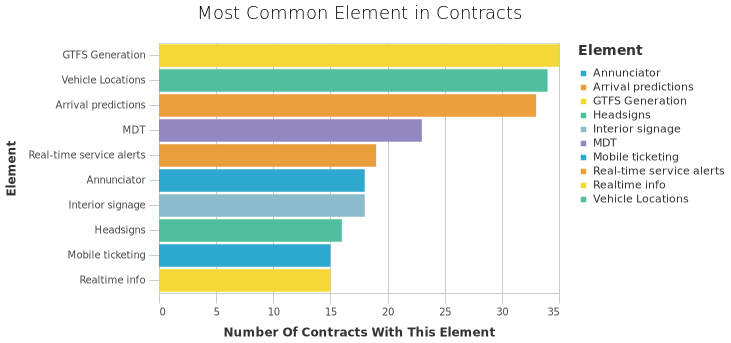

In [84]:
most_used_comps = (
    service_components2.groupby("components_orgs_actually_use")
    .agg({"provider__from_services_": "nunique"})
    .sort_values("provider__from_services_", ascending=False)
    .reset_index()
    .rename(
        columns={
            "components_orgs_actually_use": "Components Used",
            "provider__from_services_": "Count of Organizations",
        }
    )
    .head(10)
)

In [85]:
most_used_comps

,Components Used,Count of Organizations
0,Real-time info,86
1,Scheduling (Fixed-route),81
2,GTFS generation,79
3,Cash Farebox,76
4,Arrival predictions,73
5,AVL Software,70
6,Mobile data terminal software,55
7,Annunciator,52
8,Headsigns,50
9,APC Software,48


In [86]:
utils.basic_bar_chart(
    most_used_comps,
    "Count of Organizations",
    "Components Used",
    "Components Used",
    "Most Popular Components Organizations Use",
)

alt.Chart(...)

## Components with the most products to choose from
***

* Looking at the vendor that is the most popular by component. 
    * AKA which vendor has the most unique customers for a particular component.
* GMV Syncromatics Inc is the most frequent vendor - 7 out of the 27 components.

In [146]:
comp_most_products = (
    service_components2.groupby(
        ["components_orgs_actually_use", "product"]
    )
    .agg({"provider__from_services_": "nunique"})
    .rename(columns={"provider__from_services_": "Number of Customers"})
    .reset_index()
)

In [145]:
service_components2.head(1)

,name,services,components_orgs_actually_use,vendor__from_product_,parent_organization__from_vendor___from_product_,provider__from_services_,product,all_components_in_product,contained
0,"GET Bus, GET Bus On Demand-Genfare Farebox (Unspecified)-Cash Farebox","GET Bus,GET Bus On Demand",Cash Farebox,Genfare,N/A,Golden Empire Transit District,Genfare Farebox (Unspecified),Cash Farebox,True


In [147]:
comp_most_products2 = (
    comp_most_products.groupby("components_orgs_actually_use")
    .agg({"product": "nunique"})
    .reset_index()
    .sort_values("product", ascending=False)
    .rename(
        columns={
            "components_orgs_actually_use": "Components Used",
            "product": "Total Unique Products",
        }
    )
    .head(10)
)

In [148]:
utils.basic_bar_chart(
    comp_most_products2,
    "Total Unique Products",
    "Components Used",
    "Components Used",
    "Components with the most Products Available",
)

alt.Chart(...)

## Vendor x Component (Used)
***

### Look at the vendors with the most customers by component
***

In [ ]:
# Only keep the vendor with a particular component that is most popular.
# https://stackoverflow.com/questions/43899886/how-do-i-just-keep-the-rows-with-the-maximum-value-in-a-column-for-items-of-the
vendor_comp2 = vendor_comp.loc[
    vendor_comp.groupby("components_orgs_actually_use")["Number of Customers"].idxmax()
].rename(
    columns={
        "components_orgs_actually_use": "Component",
        "vendor__from_product_": "Most Frequent Vendor",
    }
)

In [ ]:
len(vendor_comp2)

26

In [ ]:
# Look at the vendors with the most customers
vendor_comp2

,Component,Most Frequent Vendor,Number of Customers
0,APC Sensors,UTA,1
17,APC Software,UTA,11
20,AVL On-board Computer,Connexionz Inc.,1
31,AVL Software,GMV Syncromatics Inc,16
51,Alerts Content Management System,GMV Syncromatics Inc,7
68,Annunciator,GMV Syncromatics Inc,11
84,Arrival predictions,GMV Syncromatics Inc,16
92,Cash Farebox,Genfare,49
97,Contactless Payment Validators,Token Transit,2
98,Fare card system,Sacramento Area Council of Governments,5


In [ ]:
vendor_comp2["Most Frequent Vendor"].value_counts()

GMV Syncromatics Inc                      7
UTA                                       2
Connexionz Inc.                           2
Genfare                                   2
Token Transit                             2
Trillium Inc.                             2
Sacramento Area Council of Governments    1
Hanover Displays Ltd                      1
TransTrack Solutions Group                1
Elavon                                    1
Transit App Inc.                          1
IBI                                       1
N/A                                       1
DoubleMap Inc.                            1
Microsoft                                 1
Name: Most Frequent Vendor, dtype: int64

In [149]:
vendor_top_comps =  utils.value_counts_df(vendor_comp2, "Most Frequent Vendor").head(5).rename(columns ={'index':'Vendor','Most Frequent Vendor':'# of Products'})

In [155]:
vendor_top_comps.style.hide(axis = 'index').set_properties(**{"background-color": "white"}).set_table_styles(
    [dict(selector="th", props=[("text-align", "center")])]
).set_properties(
    **{"text-align": "center"}
)

Vendor,# of Products
GMV Syncromatics Inc,7
UTA,2
Connexionz Inc.,2
Genfare,2
Token Transit,2


### Which vendors have the most components available for purchase
***
* Some different vendors are mixed together. Not sure how to address this. 
    * Dilax Inc., INIT SE. 
    * Optibus,GMV Syncromatics Inc
    * Hanover Displays Ltd,Clever Devices Ltd.	
    * and more..


In [ ]:
# Change Uber Inc.
service_components3["vendor__from_product_"] = service_components3[
    "vendor__from_product_"
].replace({"Uber Inc.,Uber Inc.": "Uber Inc."})

In [ ]:
# First group vendors by products and the # of components in the product - use MAX
vendor_most_comp = (
    service_components3.groupby(["vendor__from_product_", "product"])
    .agg({"number_of_components_avail": "max"})
    .reset_index()
)

In [ ]:
# Second, group by vendor and sum up all the components among all their products.
vendor_most_comp = (
    vendor_most_comp.groupby(["vendor__from_product_"])
    .agg({"number_of_components_avail": "sum"})
    .reset_index()
    .sort_values("number_of_components_avail", ascending=False)
    .rename(
        columns={
            "vendor__from_product_": "Vendor",
            "number_of_components_avail": "Total Components",
        }
    )
)

In [ ]:
# Take out N/A?
vendor_most_comp = vendor_most_comp.loc[vendor_most_comp["Vendor"] != "N/A"]

In [ ]:
vendor_most_comp.head(5)

,Vendor,Total Components
94,Uber Inc.,22
33,GMV Syncromatics Inc,22
42,Hanover Displays Ltd,18
88,Trapeze Group,17
79,Swiftly Inc.,16


### Which vendors have the most customers?
***

In [ ]:
vendors_most_customers = service_components2.loc[
    service_components2["vendor__from_product_"] != "N/A"
]

In [ ]:
vendors_most_customers = (
    vendors_most_customers.groupby("vendor__from_product_")
    .agg({"provider__from_services_": "nunique"})
    .sort_values("provider__from_services_", ascending=False)
    .reset_index()
    .head(10)
    .rename(
        columns={
            "vendor__from_product_": "Vendor",
            "provider__from_services_": "Number of Customers",
        }
    )
)

In [ ]:
utils.basic_bar_chart(
    vendors_most_customers,
    "Number of Customers",
    "Vendor",
    "Vendor",
    "Vendor with the most Customers",
)

alt.Chart(...)

## Parent Company x Vendor
***

In [103]:
# As there are a lot of N/A for the parent org, filter out N/A
parent_comp = service_components2.loc[
    service_components2["parent_organization__from_vendor___from_product_"] != "N/A"
]

In [104]:
f"only {len(parent_comp)} rows left after filtering out for populated parent organization from vendor"

'only 240 rows left after filtering out for populated parent organization from vendor'

In [105]:
parent_comp.parent_organization__from_vendor___from_product_.nunique()

7

In [106]:
parent_comp.head(1)

,name,services,components_orgs_actually_use,vendor__from_product_,parent_organization__from_vendor___from_product_,provider__from_services_,product,all_components_in_product,contained
4,"Roseville Transit, Roseville Dial-A-Ride-GMV/Syncromatics Sync -Real-time info","Roseville Transit,Roseville Dial-A-Ride",Real-time info,GMV Syncromatics Inc,GMV S.A.,City of Roseville,GMV/Syncromatics Sync,"Real-time info,Mobile trip planning app",True


In [107]:
parent_comp.groupby(["parent_organization__from_vendor___from_product_"]).agg(
    {"provider__from_services_": "nunique"}
)

,provider__from_services_
parent_organization__from_vendor___from_product_,
Everbridge,1
Fidelity National Information Services,2
GMV S.A.,18
Modaxo Inc,19
"Siemens AG, HaCon AG, INIT SE",1
TransLoc,17
"TransLoc, Everbridge",1


## Looking into 5 categories more in depth
***

In [108]:
# Drop duplicate vendor-organization-product
in_depth = service_components2.drop_duplicates(
    subset=[
        "vendor__from_product_",
        "provider__from_services_",
        "product",
        "all_components_in_product",
    ]
)

In [109]:
len(in_depth)

697

In [110]:
service_components2.columns

Index(['name', 'services', 'components_orgs_actually_use',
       'vendor__from_product_',
       'parent_organization__from_vendor___from_product_',
       'provider__from_services_', 'product', 'all_components_in_product',
       'contained'],
      dtype='object')

In [111]:
subset_list = [
    "GTFS generation",
    "AVL Software",
    "Mobile ticketing",
    "Real-time info",
    "Scheduling (Fixed-route)",
]

In [112]:
# new dataframe with only the components in our list
in_depth2 = in_depth[in_depth.components_orgs_actually_use.isin(subset_list)]

In [113]:
in_depth2 = (in_depth2.groupby(['components_orgs_actually_use','vendor__from_product_'])
             .agg({'provider__from_services_':'nunique'})
             .reset_index()
             .rename(columns = {'components_orgs_actually_use':'Components','vendor__from_product_':'Vendor','provider__from_services_':'Total Customers'}) 
            )

In [114]:
for i in subset_list:
    utils.fancy_bar_chart(
        (in_depth2[(in_depth2.Components == i)])
        .sort_values("Total Customers", ascending=False)
        .head(5),
        "Total Customers",
        "Vendor",
        "Total Customers",
        f"Top 5 Vendors in {i}",
    )

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

## Agency Info - Most "Popular" Vendors in  Real Time Info Category
***
* In response to [Lauren's question](https://docs.google.com/presentation/d/1zOOzmIuKzGoioBAbwL0Ojeq-zCOsaCyxwUbn-WPkkt8/edit#slide=id.g11c26f6eed0_0_13)
* Using Service Components data set, since it's more accurate.

In [115]:
# Only search for vendors in the chart Lauren referenced.
agency1 = service_components2[
    service_components2["vendor__from_product_"].str.contains("Cubic")
    | service_components2["vendor__from_product_"].str.contains("Connexionz")
    | service_components2["vendor__from_product_"].str.contains("Swiftly")
    | service_components2["vendor__from_product_"].str.contains("DoubleMap")
    | service_components2["vendor__from_product_"].str.contains("Bishop Peak")
] 

In [116]:
agency1.components_orgs_actually_use.unique()

array(['Interior signage', 'Alerts Content Management System',
       'Real-time info', 'Mobile data terminal software',
       'Arrival predictions', 'APC Software', 'AVL Software',
       'Offboard signage', 'GTFS generation', 'Location Sensors',
       'AVL On-board Computer', 'Annunciator', 'Headsigns',
       'Scheduling (Fixed-route)', 'N/A', 'Mobile ticketing',
       'KPI Reporting'], dtype=object)

In [117]:
#Only search for real time
agency1=agency1[agency1['components_orgs_actually_use'] == 'Real-time info'] 

In [118]:
len(agency1)

67

In [119]:
f"{agency1.vendor__from_product_.nunique()} different vendor combinations"

'7 different vendor combinations'

In [120]:
# Shorten vendor group to only the 5 vendors we care about
# https://stackoverflow.com/questions/61811137/based-on-partial-string-match-fill-one-data-frame-column-from-another-dataframe
vendors_list = [
    "Connexionz Inc.",
    "Cubic",
    "Bishop Peak Technologies",
    "DoubleMap Inc.",
    "Swiftly Inc.",
]

In [121]:
# Fill in vendor from product column with various combinations of vendors.
agency1["vendor_use"] = agency1["vendor__from_product_"].apply(
    lambda x: "".join([part for part in vendors_list if part in x])
)

In [122]:
len(agency1)

67

In [123]:
# Group by vendor and provider
agency_group = (
    agency1.groupby(["vendor_use", "provider__from_services_"])
    .agg({"services": "nunique"})
    .reset_index()
)

In [124]:
# replace providers as this is the column we merge on with Cal ITP's data later.
agency_group["provider__from_services_"] = agency_group[
    "provider__from_services_"
].replace(
    {
        " Davis": "University of California, Davis",
        " Berkeley": "University of California, Berkeley",
        "City of Fairfield": "City of Fairfield, California",
        "Gold Coast Transit": "Gold Coast Transit District",
        "OmniTrans": "Omnitrans",
        "Placer County": "County of Placer",
        "Tuolumne County Transit Agency": "Tuolumne County Transit",
        "Nevada County": "Nevada County Transit Services",
        "Los Angeles": "City of Los Angeles",
        " Solano County Transit": "Solano County Transit",
        "City of Visalia ": "City of Visalia",
        'Tulare County Regional Transit Agency':'Tulare County Area Transit',
        'County of Sonoma ': 'County of Sonoma',
       'Kern County': 'Kern Regional Transit',
        'Stanislaus Regional Transit Authority': 'Stanislaus County dba: Stanislaus Regional Transit',
        "Los Angeles County Metropolitan Transportation Authority": "Los Angeles County Metropolitan Transportation Authority ",
    }
)

In [125]:
# Merge in NTD data from Cal ITP airtable
ntd = to_snakecase(pd.read_csv(f"{GCS_FILE_PATH}NTD agency info-Grid view.csv"))

In [142]:
#agency_group.sort_values(by = 'provider__from_services_').provider__from_services_.unique()

In [143]:
#ntd.sort_values(by = 'agency_name').agency_name.unique()

In [128]:
merge1 = pd.merge(
    agency_group,
    ntd,
    left_on="provider__from_services_",
    right_on="agency_name",
    how="left",
    indicator=True,
)

In [129]:
merge1._merge.value_counts()

both          48
left_only     14
right_only     0
Name: _merge, dtype: int64

In [130]:
merge1.loc[merge1['_merge']=='left_only']

,vendor_use,provider__from_services_,services,ntd_id,legacy_ntd_id,agency_name,reporter_acronym,doing_business_as,reporter_status,reporter_type,reporting_module,organization_type,reported_by_ntd_id,reported_by_name,subrecipient_type,fy_end_date,original_due_date,address_line_1,address_line_2,p_o__box,city,state,zip_code,zip_code_ext,region,url,fta_recipient_id,duns_number,service_area_sq_miles,service_area_pop,primary_uza,uza_name,tribal_area_name,population,density,sq_miles,voms_do,voms_pt,total_voms,volunteer_drivers,personal_vehicles,organizations,_merge
0,Bishop Peak Technologies,California State University Long Beach,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
14,Cubic,University of California,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
23,Cubic,Gold Coast Transit District,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
27,Cubic,Sonoma County,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
28,Cubic,Tahoe Transportation District,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
30,DoubleMap Inc.,California Pacific Medical Center,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
33,DoubleMap Inc.,City of Beaumont,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
36,DoubleMap Inc.,First Transit,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
37,DoubleMap Inc.,Kaiser Permanente,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
38,DoubleMap Inc.,Mission Bay Transportation Management Agency,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [131]:
# Fill in null values for columns to group on
merge1["reporting_module"].fillna(value="N/A", inplace=True)
merge1["service_area_pop"].fillna(value=0, inplace=True)

In [132]:
len(merge1)

62

In [133]:
rural_urban = merge1.groupby(
    [
        "vendor_use",
        "reporting_module",
    ]
).agg({"provider__from_services_": "nunique"})
rural_urban

provider__from_services_
vendor_use               reporting_module                          
Bishop Peak Technologies Asset                                    1
                         N/A                                      1
                         Rural                                    2
                         Urban                                    2
Connexionz Inc.          Urban                                    7
Cubic                    N/A                                      4
                         Urban                                   12
DoubleMap Inc.           N/A                                      8
                         Rural                                    3
                         Urban                                    6
Swiftly Inc.             Asset                                    1
                         N/A                                      1
                         Rural                                    3
                         Urban                                   11

In [134]:
p75 = merge1.service_area_pop.quantile(0.75).astype(float)
p25 = merge1.service_area_pop.quantile(0.25).astype(float)
p50 = merge1.service_area_pop.quantile(0.50).astype(float)

In [135]:
# Function to give a rough estimate whether an agency is small, medium, or large based on the service population column
def pop_served(row):
    if (row.service_area_pop > p25) and (row.service_area_pop < p50):
        return "Small"
    elif (row.service_area_pop > p50) and (row.service_area_pop < p75):
        return "Medium"
    elif row.service_area_pop == 0:
        return "No Info"
    else:
        return "Large"

In [136]:
merge1["agency_size_based_on_service_population"] = merge1.apply(
    lambda x: pop_served(x), axis=1
)

In [137]:
# Double check
merge1[
    [
        "provider__from_services_",
        "service_area_pop",
        "agency_size_based_on_service_population",
    ]
].sample(3)

,provider__from_services_,service_area_pop,agency_size_based_on_service_population
33,City of Beaumont,0.00,No Info
50,City of Turlock,87867.00,Medium
24,Omnitrans,1500107.00,Large


In [138]:
size = merge1.groupby(
    [
        "vendor_use",
        "agency_size_based_on_service_population",
    ]
).agg({"provider__from_services_": "nunique"})
size

provider__from_services_
vendor_use               agency_size_based_on_service_population                          
Bishop Peak Technologies Medium                                                          1
                         No Info                                                         3
                         Small                                                           1
Connexionz Inc.          Large                                                           3
                         Medium                                                          4
Cubic                    Large                                                           7
                         Medium                                                          3
                         No Info                                                         4
                         Small                                                           2
DoubleMap Inc.           Medium                                                          3
                         No Info                                                        11
                         Small                                                           3
Swiftly Inc.             Large                                                           6
                         Medium                                                          4
                         No Info                                                         5
                         Small                                                           1

In [139]:
agency_info = merge1[
    [
        "vendor_use",
        "provider__from_services_",
        "service_area_pop",
        "agency_size_based_on_service_population",
        "reporter_type",
        "primary_uza",
        "uza_name",
        "voms_do",
        "voms_pt",
        "total_voms",
    ]
]

In [140]:
agency_info = agency_info.fillna("N/A")

In [141]:
agency_info.sample(2)

,vendor_use,provider__from_services_,service_area_pop,agency_size_based_on_service_population,reporter_type,primary_uza,uza_name,voms_do,voms_pt,total_voms
2,Bishop Peak Technologies,City of Visalia,136246.00,Medium,Full Reporter,162.00,"Visalia, CA",N/A,39.00,39.00
24,Cubic,Omnitrans,1500107.00,Large,Full Reporter,22.00,"Riverside-San Bernardino, CA",147.00,103.00,250.00


In [144]:
# Write to Excel
with pd.ExcelWriter(f"{GCS_FILE_PATH}agency_vendor_question.xlsx") as writer:
    agency_info.to_excel(writer, sheet_name="Full_Data", index=False)